# Assignment 3
## Part A (state diagrams and transition matrices)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = 'None'
from matplotlib.patches import FancyArrowPatch, ArrowStyle

### This notebook is for sub-parts f & g.

In [2]:
def genT(AM):
    T = []
    for i in AM:
        p = np.random.dirichlet(np.ones(np.sum(i)))
        t = []; count = 0
        for j in range(len(AM)):
            if i[j]: t.append(p[count]); count+=1
            else: t.append(0)
        T.append(t)
    return T

def distribution(T, eps):
    D = []
    P0 = np.zeros(len(T))
    P0[0] = 1
    diff = 1
    while diff>eps:
        P1 = np.dot(P0, T)
        diff = np.linalg.norm(P1-P0)
        P0 = P1
        D.append(P0)
    return D

def trajectory(T):
    M = []
    s0 = np.zeros(len(T))
    s0[0] = 1
    while True:
        s1 = np.random.choice(range(len(T)), p=T[np.argmax(s0)])
        s0 = np.zeros(len(T))
        s0[s1] = 1
        M.append(s0)
        if s1 == len(T)-1: break
    return M

def show(matrix):
    plt.figure(figsize=(4,4))
    plt.imshow(matrix, cmap='hot')
    plt.xticks([]); plt.yticks([])
    plt.show()

def pos2point(pos):
    x = []; y = []
    for p in pos:
        space = 0
        for i in range(dimension):
            for j in range(dimension):
                if space==p: x.append(i); y.append(j)
                space+=1
    return y, x

def create_arrow(start, end, color):
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
    style = ArrowStyle('simple', head_length=10, head_width=14, tail_width=6)
    arrow = FancyArrowPatch(start, end, fc=color, ec='k', arrowstyle=style, alpha=0.5)                     
    return arrow

def showGraph(A):
    graph = nx.from_numpy_array(np.array(A), create_using=nx.DiGraph)
    fig, ax = plt.subplots(figsize=(4,4))
    nx.draw(graph, nx.shell_layout(graph), with_labels=True, node_size=200, 
            node_color='lightblue', font_size=10, arrows=True)
    fig.set_facecolor('None')
    plt.show()

def showGame(showPath=False):
    plt.figure(figsize=(4,4))
    plt.imshow(np.zeros((dimension, dimension)), cmap='hot')
    if showPath: 
        plt.plot(pathX, pathY, c='w', marker='o', ls=':')
    for i in range(len(headX)):
        arrow = create_arrow((headX[i], headY[i]), (tailX[i], tailY[i]), 'r')
        plt.gca().add_patch(arrow)
    for i in range(len(tops)):
        arrow = create_arrow((topX[i], topY[i]), (botX[i], botY[i]), 'b')
        plt.gca().add_patch(arrow)
    plt.xticks(np.arange(-.5, dimension, 1), minor=True)
    plt.yticks(np.arange(-.5, dimension, 1), minor=True)
    plt.xticks([]); plt.yticks([])
    ax = plt.gca()
    ax.grid(which='minor', ls='-', lw=2, c='gray', alpha=0.5)
    ax.tick_params(which='both', length=0)
    plt.show()

In [3]:
size = 25
#can certainly change this, but it leaves out ambiguity
assert np.sqrt(size) == int(np.sqrt(size)), 'size must be square'
die = 5

To build the boardgame, which we're currently assuming to be (5x5) not (25x25), <br>
we first imagine the most simple situation: no snakes, no ladders. <br>
We start at square 0, and roll our D5, moving 1-5 spaces forward, rince and repeat. <br><br>
For the adjacency matrix, we should first try identify the pattern.

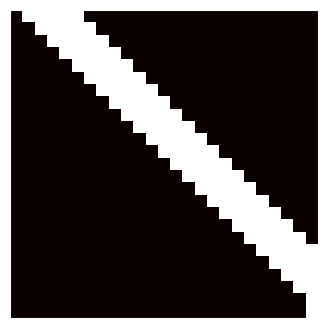

In [4]:
#basic pattern
A0 = [0] + [1]*die + [0]*(size-die-1)
A1 = [0]*2 + [1]*die + [0]*(size-die-2)

#iterate it
A = [[0]*(i+1) + [1]*die + [0]*(size-die-(i+1)) for i in range(size)]

#shave off the excess
A = [a[:size] for a in A]

#last space connects exclusively to itself, such that we may win forever
A[size-1][size-1] = 1
A = np.array(A)
show(A)

#### To visualize this as a graph, we can use $networkx$

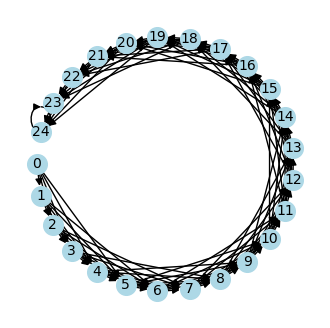

In [5]:
showGraph(A)

#### Next we add snakes and ladders, which are basically portals, ie additional connections
* We can do so randomly, although the nuances here are surprisingly tricky
* Snakes are connections bottom left of the diagonal, and ladders top right
* If we wanted them all to be two-way portals instead, we'd make the matrix symmetric
* We first generate the snake and ladder positions, with some restrictions:
    * Snakes and ladders cannot share starting points
    * Nor can snakes and ladders end where they begin
        * Otherwise we might be making more than one move per iteration
    * However, snakes and ladders can share end points
* Then, we ensure each row with a snake or ladder only has that one connection

<br>

#### To do this we use 2 arrays
* $A$ is the original board with the natural dice moves along the diagonal
* $B$ distinguishes snake and ladder zones and will contain all final S&L positions
* Then we'll remove the appropriate spaces from $A$ based on $B$
* And finally superimpose them to make the adjacency matrix $A_{dj}=A+B$

In [6]:
def valid(connections):
    X = [i[0] for i in connections]
    Y = [i[1] for i in connections]
    #check for unique start points
    if len(np.unique(X)) != len(Y): return False
    #check no matching starts and ends
    for x in X:
        for y in Y:
            if x==y: return False
    return True

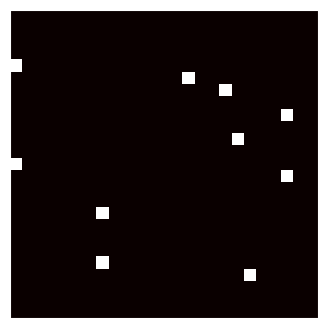

In [7]:
#First enumerate all possible snake and ladder positions
snakes = []; ladders = []
for i in range(1, size-1):
    for j in range(0, i+1):
        if i!=j: snakes.append((i, j))
for i in range(1, size):
    for j in range(i+1+die, size):
        if i!=j: ladders.append((i, j))

#Set snake and ladder variables
s = 5
l = 5

#Note that this may run forever if above variables don't fit board size
while True:
    B = np.zeros((size,size),  dtype=int)
    snake = np.random.choice(np.arange(len(snakes)), s, replace=False)
    ladder = np.random.choice(np.arange(len(ladders)), l, replace=False)
    for i in snake: B[snakes[i]] = 1
    for i in ladder: B[ladders[i]] = 1
    if all((np.sum(B[i]) < np.sum(A[i]) for i in range(size-1))):
        connections = [snakes[i] for i in snake]+[ladders[i] for i in ladder]
        if valid(connections): break

show(B)
#Save lists of snakes and ladders
heads = [snakes[s][0] for s in snake]
tails = [snakes[s][1] for s in snake]
tops = [ladders[l][0] for l in ladder]
bots = [ladders[l][1] for l in ladder]

Finally we can build the adjacency matrix proper

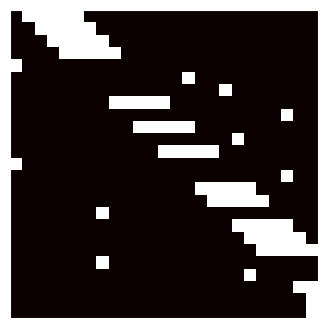

In [8]:
Adj = A.copy()
#remove normal space distribution if row has snake or ladder
B = B.reshape(size,size)
for i in range(size-1):
    if any(B[i]):
        moves = np.where(A[i]==1)[0]
        for m in moves: Adj[i][m] = 0
#combine this matrix with snakes and ladders
Adj = Adj+B
show(Adj)

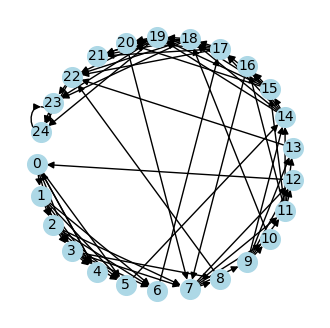

In [9]:
#We can see how this changes the graph
showGraph(Adj)

Now that we have a proper adjacency matrix, we can use the algorithms from part 1 to generate the associated transition matrix $T$, distribution $D$, as well as any number of possible Monte Carlo paths $M$

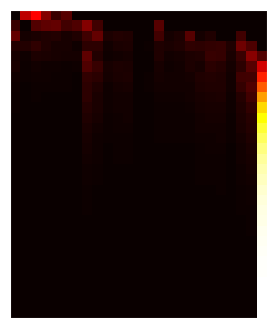

In [10]:
#Note that we have adjusted D, such that it converges when diff<epsilon
T = genT(Adj)
M = trajectory(T)
D = distribution(T, eps=1e-3)
show(D)

#### Finally we can make use of those verbose functions at the top to generate some nice visualizations for our boardgame, including the snakes (red), ladders (blue), and a possible path (white).

rolls: 22


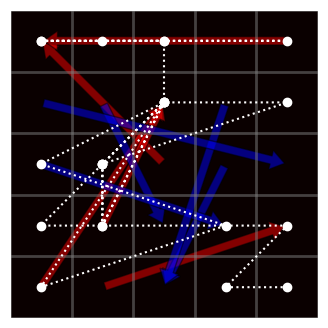

path: 0 2 4 0 1 2 7 10 18 20 7 9 11 16 7 11 16 7 11 15 19 23 24


In [11]:
path = [0]+[np.argmax(i) for i in M]
dimension = int(np.sqrt(size))

#Convert transition matrix indicies to game (x,y)
pathX, pathY = pos2point(path)
headX, headY = pos2point(heads)
tailX, tailY = pos2point(tails)
topX, topY = pos2point(tops)
botX, botY = pos2point(bots)

#Show visualization
print('rolls:', len(M))
showGame(showPath=True)
print('path:', *path)

For further tests, see testing.ipynb

In [12]:
###/END